# Analysis of publications along the efficient frontier using pygmo

In [271]:
import scipy
import pandas as pd
import plotnine as pn
import numpy as np

import matplotlib.pyplot as plt
import warnings
import matplotlib.gridspec as gridspec


from tqdm import tqdm



In [272]:
vectorizer = "SciBERT"
num_quantiles = 100

In [273]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,1545.550332,0.814415,42,2.250000,False,2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f,2004,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
1,1846.261870,0.452021,88,4.625000,False,d7b6cd39dd111afa55a3aa418b7b5459db12988d,2012,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
2,1703.520959,0.490212,30,0.882353,False,2d62ec65f95435c72ef750b3cff331382c5dca92,2003,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
3,1901.386693,0.715160,95,8.166667,False,8cebc6e3dcfb543bad48d89112e281a6e11c33c2,2014,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
4,535.472125,0.885892,94,2.090909,False,59730a4bae4dc53f59341b63fd1e63451c589e9f,2009,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
537685,48.730838,0.658585,41,3.500000,False,806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24,2018,S2,SciBERT,Andre2018,Mathematics
537686,25.107589,0.721374,38,3.200000,False,f40707d1165c22e185c25e6837977177ee380f2c,2015,S2,SciBERT,Andre2018,Mathematics
537687,41.647954,0.646499,11,1.529412,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
537688,35.738649,0.708053,15,2.384615,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics


In [274]:
# Basic nan handling across all obs
df_all["log_cpy"] = np.log10(df_all["citations_per_year"])
df_all['log_cpy'] = df_all['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


In [275]:
field_names = sorted(df_all["fields_of_study_0"].unique())
field_names

['Economics',
 'Education',
 'Geology',
 'Linguistics',
 'Materials Science',
 'Mathematics',
 'Medicine',
 'Philosophy',
 'Physics']

In [276]:
vectorizer_names = sorted(df_all["vectorizer"].unique())
vectorizer_names

['BOW', 'GPT2', 'SBERT', 'SciBERT', 'Word2Vec']

In [277]:
df = df_all[df_all["vectorizer"] == vectorizer]

In [278]:
# Helper function for z-scaling
def zscale(df_in: pd.DataFrame, col: str) -> pd.DataFrame:
    result = (df_in[col] - np.nanmean(df_in[col])) / np.nanstd(df_in[col])
    return result

In [279]:
def bin_measurements(df_in: pd.DataFrame, field: str, num_quantiles: int) -> pd.DataFrame:
    """Given a dataframe and a field to subset to, cut density observations into `num_bins` and compute statistics of the resulting citation distribution induced by the density class."""

    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # Filter within reasonable values
    # First get z-scales for density and citation rates
    for col in ["density", "citations_per_year"]:
        df[f"{col}_z"] = zscale(df, col)

    # For density bin
    density_bin_max = df["density_z"] < 3
    density_bin_min = df["density_z"] > -3
    # For cpy
    cpy_max = df["citations_per_year_z"] < 3
    cpy_min = df["citations_per_year_z"] > -3
    # Apply masks
    df = df[density_bin_max & density_bin_min & cpy_max & cpy_min]

    # Cut into quantiles
    df["density_bin"] = pd.qcut(
        df["density"],
        q=num_quantiles,
    )

    # Group data after binning
    data_bins = df[["log_cpy", "density_bin", "citations_per_year", "references", "year"]]

    # Measure statistics
    statistics = []
    for bin_key in sorted(df.density_bin.value_counts().keys()):
        df_bin = data_bins[data_bins["density_bin"] == bin_key]
        statistics.append((
            np.nanvar(df_bin["log_cpy"].values),
            np.nanmedian(df_bin["citations_per_year"].values),
            np.nanmedian(df_bin["references"].values),
            np.nanmedian(df_bin["year"].values),
            np.nanmean(df_bin["citations_per_year"].values),
            np.nanstd(df_bin["citations_per_year"].values),
            np.nanmean(df_bin["log_cpy"].values),
            np.nanstd(df_bin["log_cpy"].values),
        ))
    
    # Construct dataframe
    df_result = pd.DataFrame(
        statistics,
        columns=[
            "log_cpy_var",
            "cpy_med",
            "ref_med",
            "year_med",
            "cpy_mean",
            "cpy_std",
            "log_cpy_mean",
            "log_cpy_std",
        ],
    )

    # Annotate by (start of) density bin
    df_result["density_bin"] = [float(item.left) for item in df.density_bin.value_counts(sort=False, normalize=True).keys()]

    # Annotate z-scales for density and citation rates
    for col in df_result.columns:
        col_z = f"{col}_z"
        df_result[col_z] = zscale(df_result, col)
        
    # Annotate counts and relative frequencies
    df_result["counts"] = df.density_bin.value_counts(sort=False, normalize=False).tolist()
    df_result["freq"] = df.density_bin.value_counts(sort=False, normalize=True).tolist()
    # Annotate field
    df_result["field"] = field

    return df_result

In [280]:
# test
bin_measurements(df, "Physics", 1000).counts.value_counts()

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_86734/1566509646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_86734/1566509646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


counts
11    964
10     28
12      6
13      1
9       1
Name: count, dtype: int64

In [281]:
df_binned_all = pd.concat(
    [bin_measurements(df, field, num_quantiles)
    for field in field_names],
)
df_binned_all.head()

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_86734/1566509646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_86734/1566509646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_86734/1566509646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,log_cpy_var,cpy_med,ref_med,year_med,cpy_mean,cpy_std,log_cpy_mean,log_cpy_std,density_bin,log_cpy_var_z,...,ref_med_z,year_med_z,cpy_mean_z,cpy_std_z,log_cpy_mean_z,log_cpy_std_z,density_bin_z,counts,freq,field
0,0.442514,0.226496,41.0,2008.0,1.416476,3.357639,-0.189315,0.665218,18.082,-1.422535,...,2.800282,-1.607820,-3.192076,-2.869285,-4.368803,-1.424619,-2.986470,150,0.010064,Economics
1,0.562017,0.300000,29.0,2009.0,2.726210,6.938873,0.027238,0.749678,22.280,0.987342,...,-1.302695,-0.577166,-1.503848,-0.966415,-1.431394,0.972527,-2.234323,149,0.009997,Economics
2,0.564395,0.333333,28.0,2008.0,2.896021,8.255875,0.005954,0.751262,23.878,1.035282,...,-1.644610,-1.607820,-1.284964,-0.266633,-1.720097,1.017480,-1.948012,149,0.009997,Economics
3,0.506010,0.562500,27.0,2008.0,3.488698,7.550062,0.139956,0.711344,24.859,-0.142092,...,-1.986525,-1.607820,-0.521012,-0.641662,0.097553,-0.115471,-1.772248,149,0.009997,Economics
4,0.470341,0.375000,27.0,2008.0,2.671076,7.265882,-0.012607,0.685814,25.470,-0.861383,...,-1.986525,-1.607820,-1.574915,-0.792660,-1.971869,-0.840046,-1.662776,149,0.009997,Economics


In [282]:
df_plot = df_binned_all.copy()

In [283]:
from pygmo import non_dominated_front_2d
from scipy import interpolate
from scipy.spatial.distance import cdist

def interpolate_frontier(points: np.ndarray, num: int) -> np.ndarray:
    """Interpolate the frontier points to obtain a dense estimated bound on efficiency.
    
    Args:
        points: a 2D array of shape `(num_optimal, 2)` representing the non-dominated (Expected Return, Risk) points.

    Returns:
        a 2D array of shape `(num, 2)` representing the interpolated frontier of points.
    """
    # TODO: check this is appropriate
    min_sigma = points.min(axis=0)[0]
    max_sigma = points.max(axis=0)[0]

    pareto_x, pareto_y = list(zip(*points))
    interpolated = interpolate.interp1d(pareto_x, pareto_y, fill_value="extrapolate")

    pareto_costs = list(set(np.linspace(min_sigma, max_sigma, num=num).tolist()))
    pareto_complexities = interpolated(pareto_costs)
    interpolated_points = np.array(list(zip(pareto_costs, pareto_complexities)))
    return interpolated_points

def pareto_min_distances(points: np.ndarray, frontier_points: np.ndarray) -> np.ndarray:
    """Measure the Pareto optimality of each point by measuring its Euclidean closeness to the frontier. The frontier is a line (list of points) interpolated from the pareto points.

    Args:

        points: a 2D array of shape `(num_observations, 2)` representing all (Expected Return, Risk) points.

        pareto_points: a 2D array of shape `(num, 2)` representing the interpolated Pareto frontier of points.

    Returns:

        min_distances: an array of shape `len(points)` Euclidean distances for each point to the closest point on the Pareto frontier. 
    """
    # Measure closeness of each language to any frontier point
    distances = cdist(points, frontier_points)
    min_distances = np.min(distances, axis=1)

    # Normalize to 0, 1 because optimality is defined in terms of 1 - dist
    min_distances /= max(min_distances)
    return min_distances

def get_frontier_data(df_in: pd.DataFrame, x="log_cpy_std_z", y="log_cpy_mean_z") -> pd.DataFrame:
    """Estimate the efficient frontier of the Markowitz bullet using pygmo's non_dominated_front_2d method.
    
    Args:
        df_in: the data to compute the efficient frontier for

    Returns:
        the subset of df_in representing the efficient frontier.
    """
    # 2D array of ()
    min_points = df_in[[x, y]].values
    min_points[:,1] *= -1

    dominating_indices = non_dominated_front_2d(min_points)
    return df_in.iloc[dominating_indices]

In [284]:
expected_return = "log_cpy_mean_z"
risk = "log_cpy_std_z"

dominant_data = get_frontier_data(df_plot, risk, expected_return)

frontier = interpolate_frontier(dominant_data[[risk, expected_return]].values, num=100)

min_dists = pareto_min_distances(
    df_plot[[risk, expected_return]].values,
    frontier,
)

df_plot["min_distances"] = min_dists
df_plot["optimality"] = 1 - min_dists

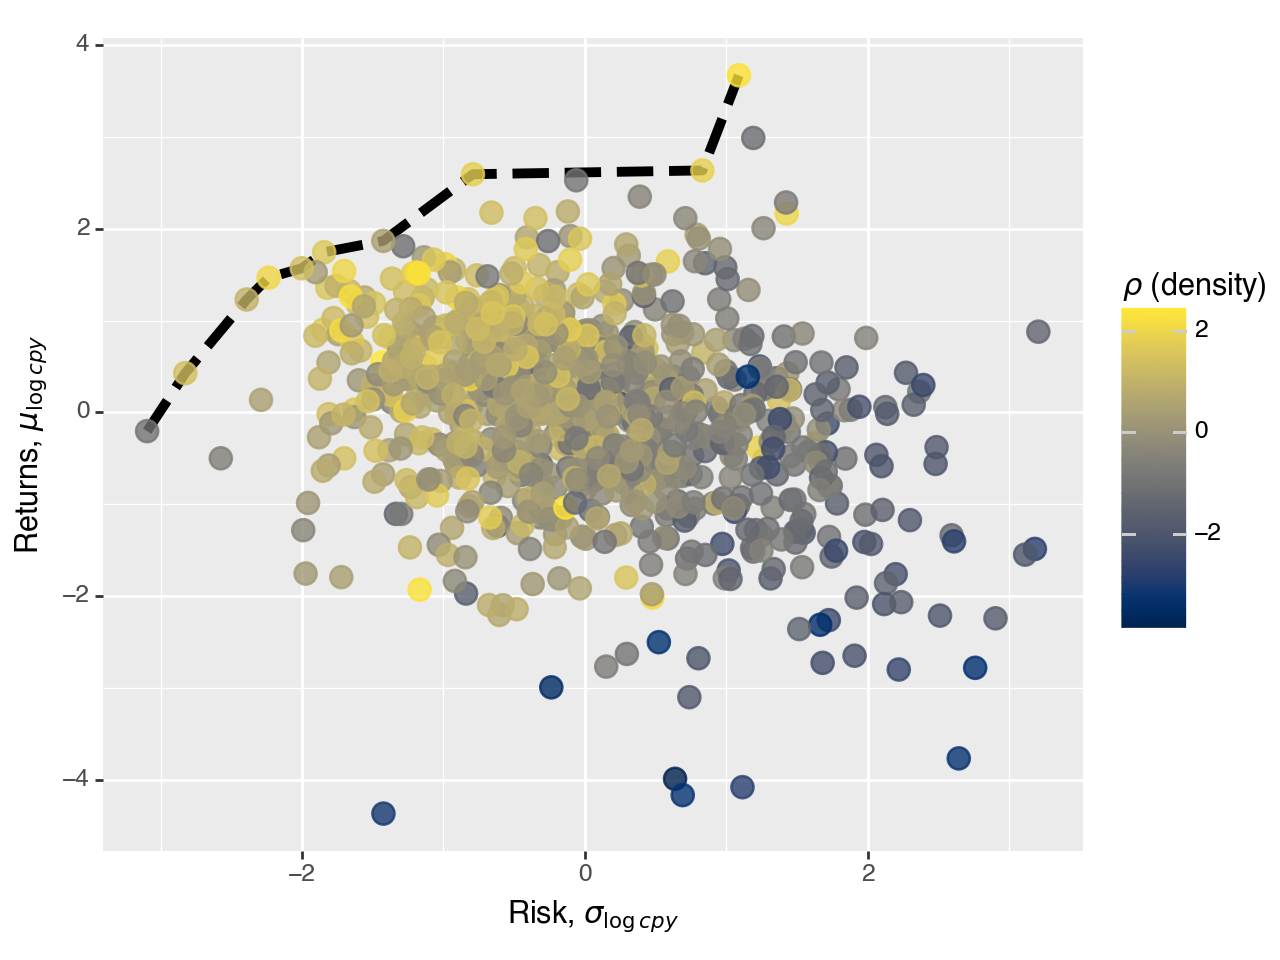

<Figure Size: (640 x 480)>

In [285]:
(
    pn.ggplot(
        df_plot,
        pn.aes(
            x=risk, # var return
            y=expected_return, # median return
            # color="density_bin_z", # 
        ),
    )
    + pn.geom_line(
        dominant_data,
        color = "black",
        size = 2,
        # alpha = 0.2,
        linetype = "dashed",
    )    
    + pn.geom_point(
        pn.aes(
            color = "density_bin_z",
            # color = "ref_med_z",
            # color = "year_med",
            # color = "optimality",
        ),
        size = 4,
        alpha = 0.8,
    )
    + pn.scale_color_continuous("cividis")
    + pn.labs(color="Density, $\\rho$")
    + pn.xlab("Risk, $\sigma_{\log cpy}$")
    + pn.ylab("Returns, $\mu_{\log cpy}$")
    # + pn.theme_classic()
)

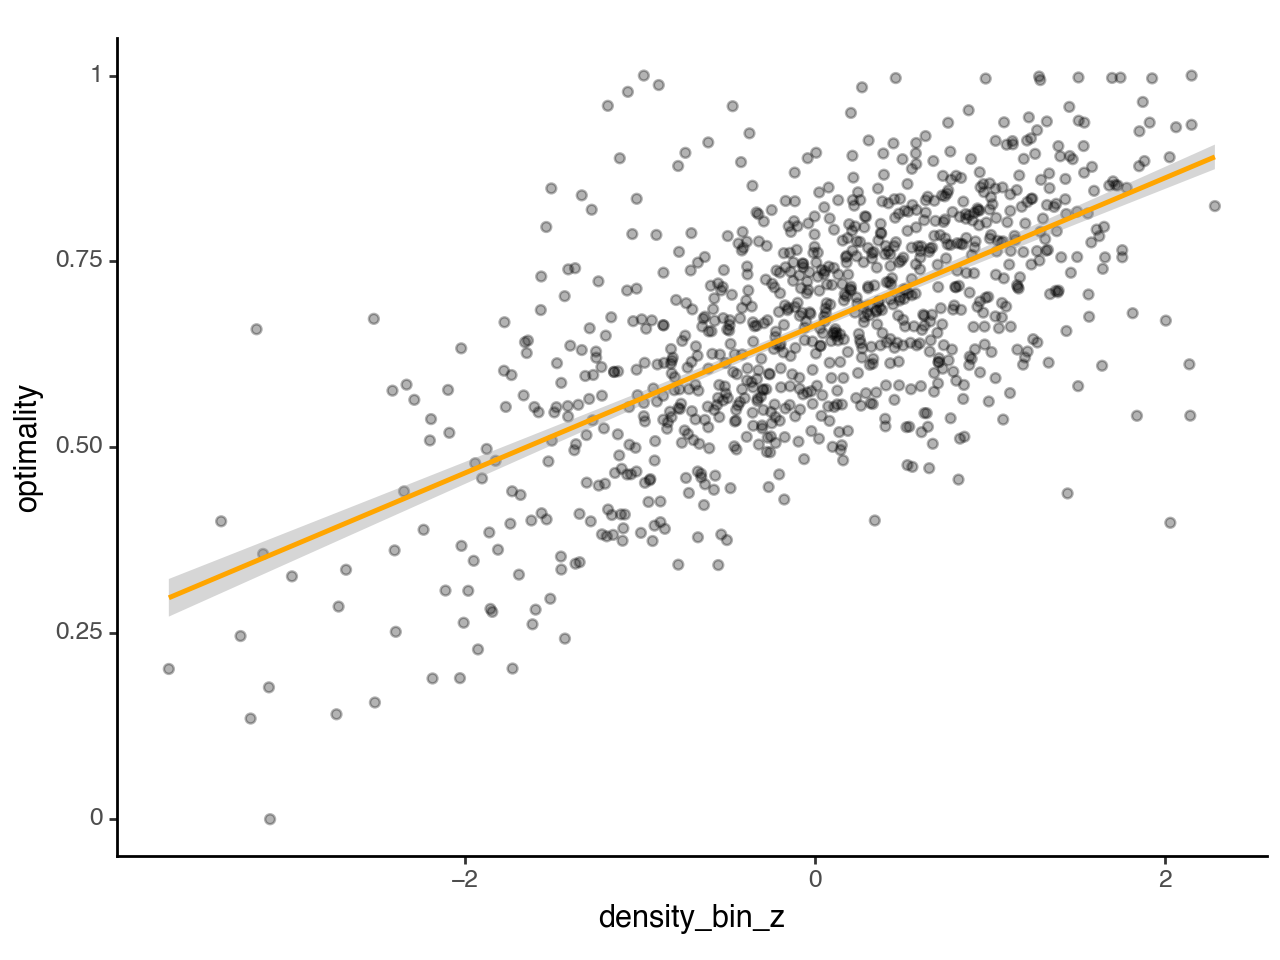

<Figure Size: (640 x 480)>

In [286]:
# Correlation with optimality
(
    pn.ggplot(
        df_plot,
        pn.aes(
            x="density_bin_z",
            y="optimality",
        ),
    )
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", level=0.9, method="lm")
    + pn.theme_classic()
)

Regressions

In [287]:
from scipy.stats import linregress

def plot_linregress(df_in: pd.DataFrame, x: str, y: str) -> pn.ggplot:
    """Run a linear regression on variables of interest and plot the result."""
    result = linregress(*df_in[[x,y]].values.T)

    return (
        pn.ggplot(
            df_in,
            pn.aes(
                x=x,
                y=y,
            )
        )
        + pn.geom_point(alpha=0.2)
        + pn.geom_smooth(method="lm", color = "orange")
        + pn.ggtitle(f"Slope={result.slope:.2f}, $R^2 =${result.rvalue**2:.2f}, $p = ${result.pvalue:.2f}")
    )

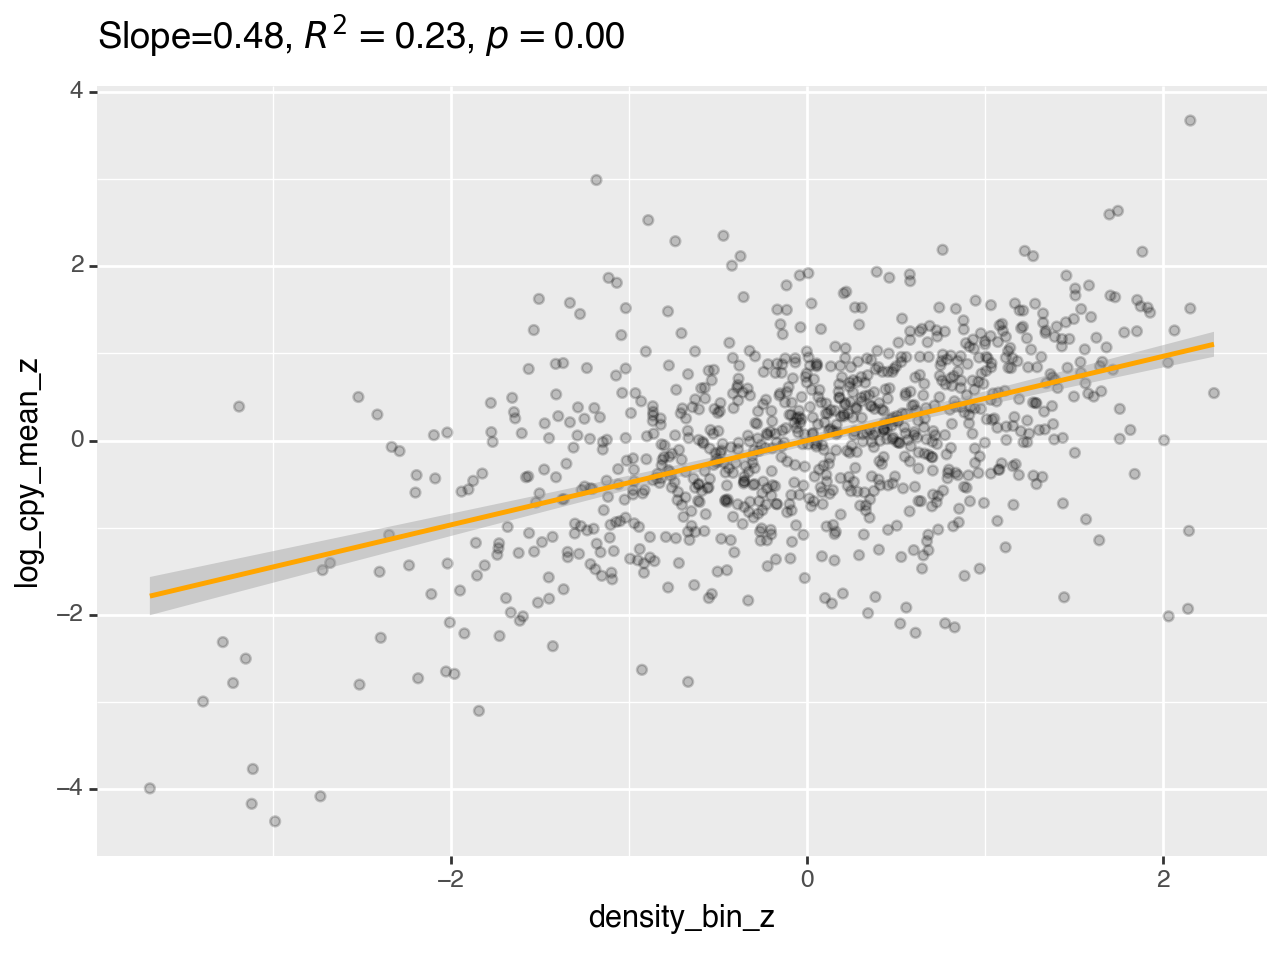

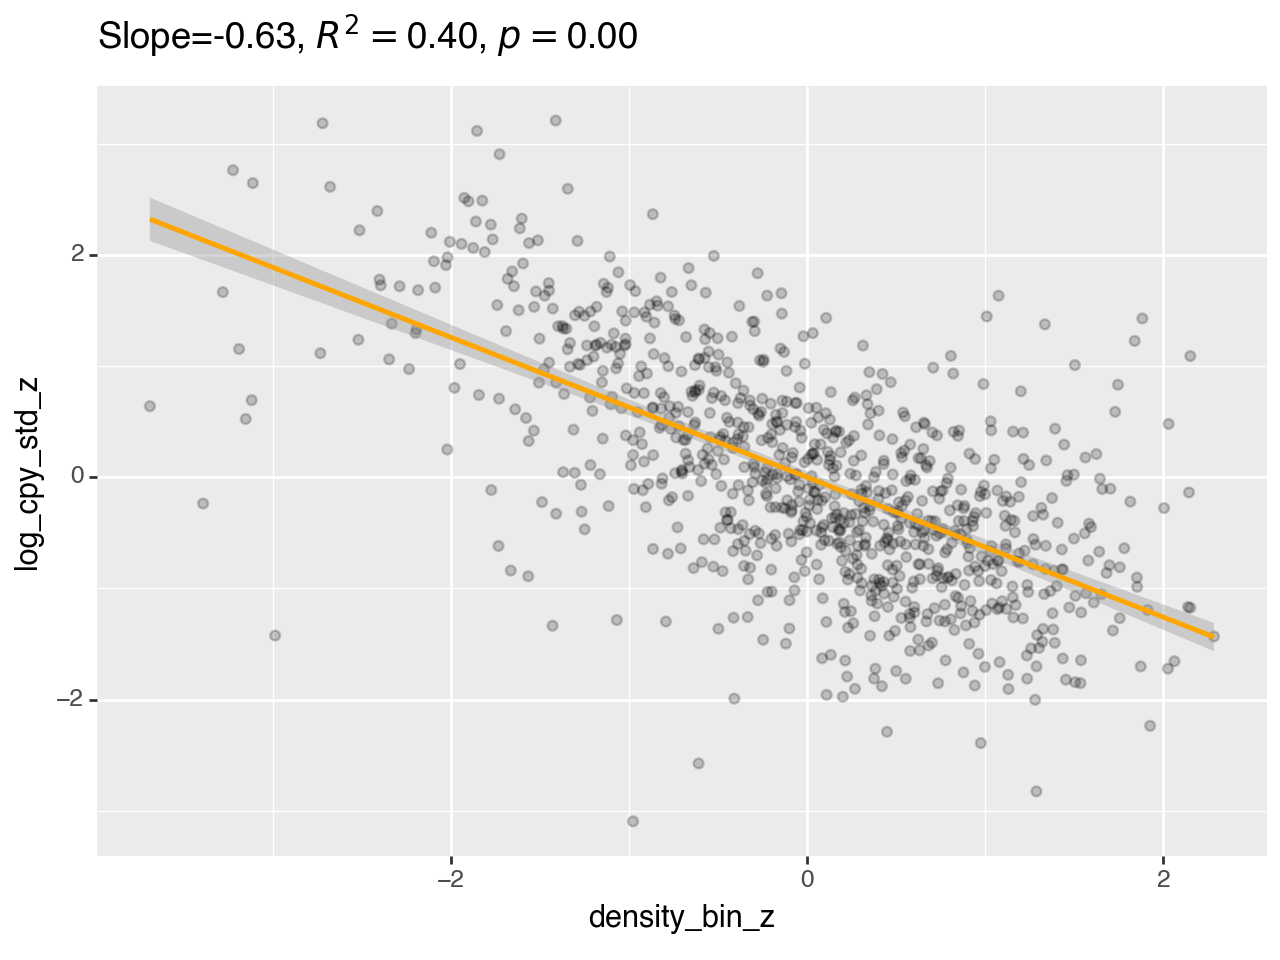

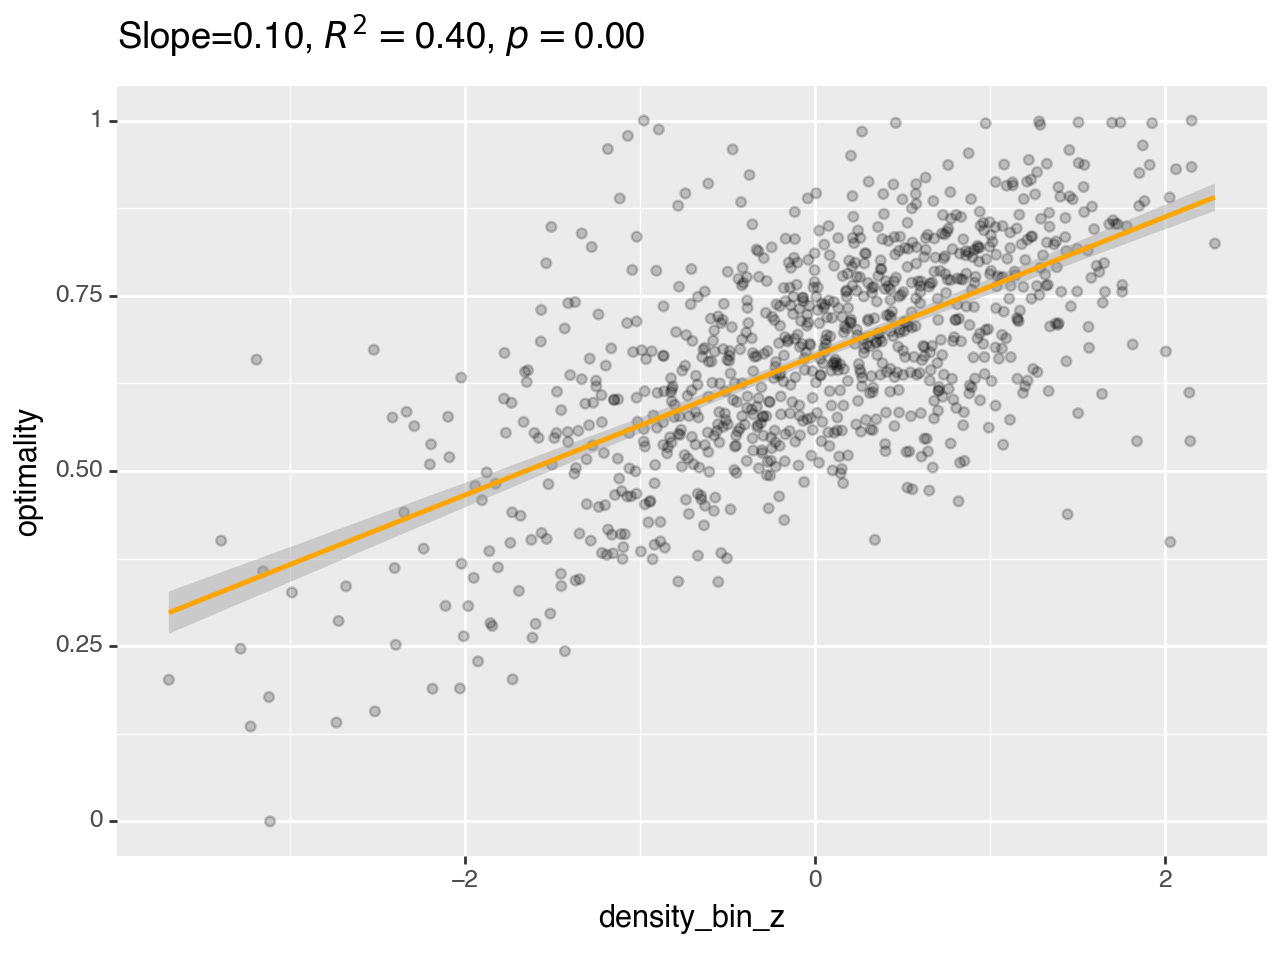

In [288]:
print(plot_linregress(df_plot, "density_bin_z", "log_cpy_mean_z"))
print(plot_linregress(df_plot, "density_bin_z", "log_cpy_std_z"))
print(plot_linregress(df_plot, "density_bin_z", "optimality"))

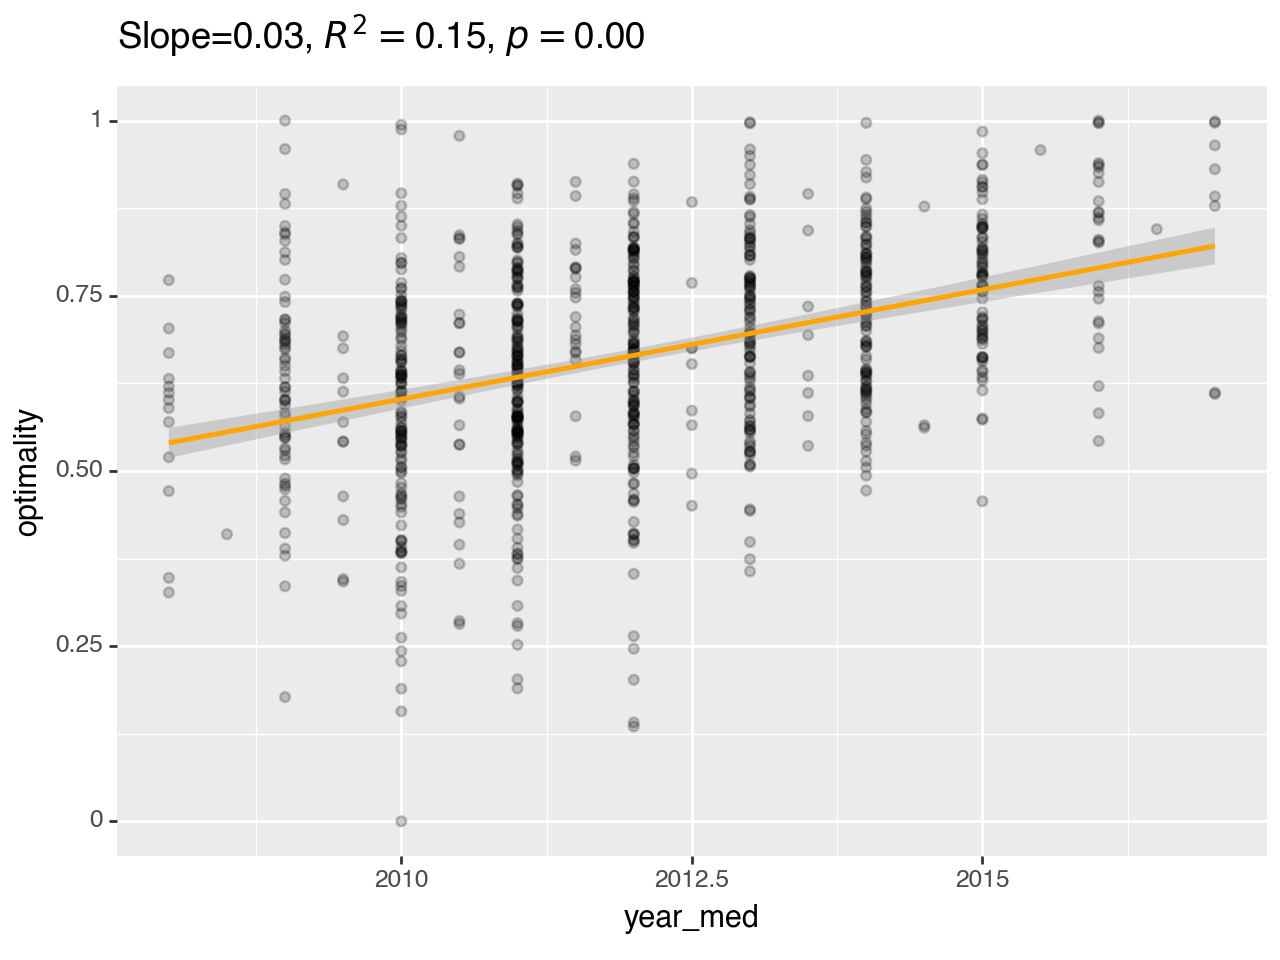

In [289]:
print(plot_linregress(df_plot, "year_med", "optimality"))

## By field

In [290]:
def annotate_optimality(df_binned: pd.DataFrame, risk: str, expected_return: str) -> pd.DataFrame:
    """Given a dataframe of binned measurements, return the dataframe annotated with optimality."""
    dominant_data = get_frontier_data(df_binned, risk, expected_return)
    frontier = interpolate_frontier(dominant_data[[risk, expected_return]].values, num=100)
    min_dists = pareto_min_distances(
        df_binned[[risk, expected_return]].values,
        frontier,
    )
    df_binned["min_distances"] = min_dists
    df_binned["optimality"] = 1 - min_dists

    # not the prettiest, but oh well
    df_binned["type"] = "observed"
    dominant_data["type"] = "dominant"
    df_out = pd.concat([df_binned, dominant_data])

    return df_out

In [291]:
risk = "log_cpy_std_z"
expected_return = "log_cpy_mean_z"

df_binned_all = pd.concat(
    [annotate_optimality(bin_measurements(df, field, num_quantiles), risk, expected_return)
    for field in field_names],
)
df_binned_all.head()

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_86734/1566509646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_86734/1566509646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_86734/105786553.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,log_cpy_var,cpy_med,ref_med,year_med,cpy_mean,cpy_std,log_cpy_mean,log_cpy_std,density_bin,log_cpy_var_z,...,cpy_std_z,log_cpy_mean_z,log_cpy_std_z,density_bin_z,counts,freq,field,min_distances,optimality,type
0,0.442514,0.226496,41.0,2008.0,1.416476,3.357639,-0.189315,0.665218,18.082,-1.422535,...,-2.869285,-4.368803,-1.424619,-2.986470,150,0.010064,Economics,1.000000,0.000000,observed
1,0.562017,0.300000,29.0,2009.0,2.726210,6.938873,0.027238,0.749678,22.280,0.987342,...,-0.966415,-1.431394,0.972527,-2.234323,149,0.009997,Economics,0.676839,0.323161,observed
2,0.564395,0.333333,28.0,2008.0,2.896021,8.255875,0.005954,0.751262,23.878,1.035282,...,-0.266633,-1.720097,1.017480,-1.948012,149,0.009997,Economics,0.733726,0.266274,observed
3,0.506010,0.562500,27.0,2008.0,3.488698,7.550062,0.139956,0.711344,24.859,-0.142092,...,-0.641662,0.097553,-0.115471,-1.772248,149,0.009997,Economics,0.259187,0.740813,observed
4,0.470341,0.375000,27.0,2008.0,2.671076,7.265882,-0.012607,0.685814,25.470,-0.861383,...,-0.792660,-1.971869,-0.840046,-1.662776,149,0.009997,Economics,0.576667,0.423333,observed


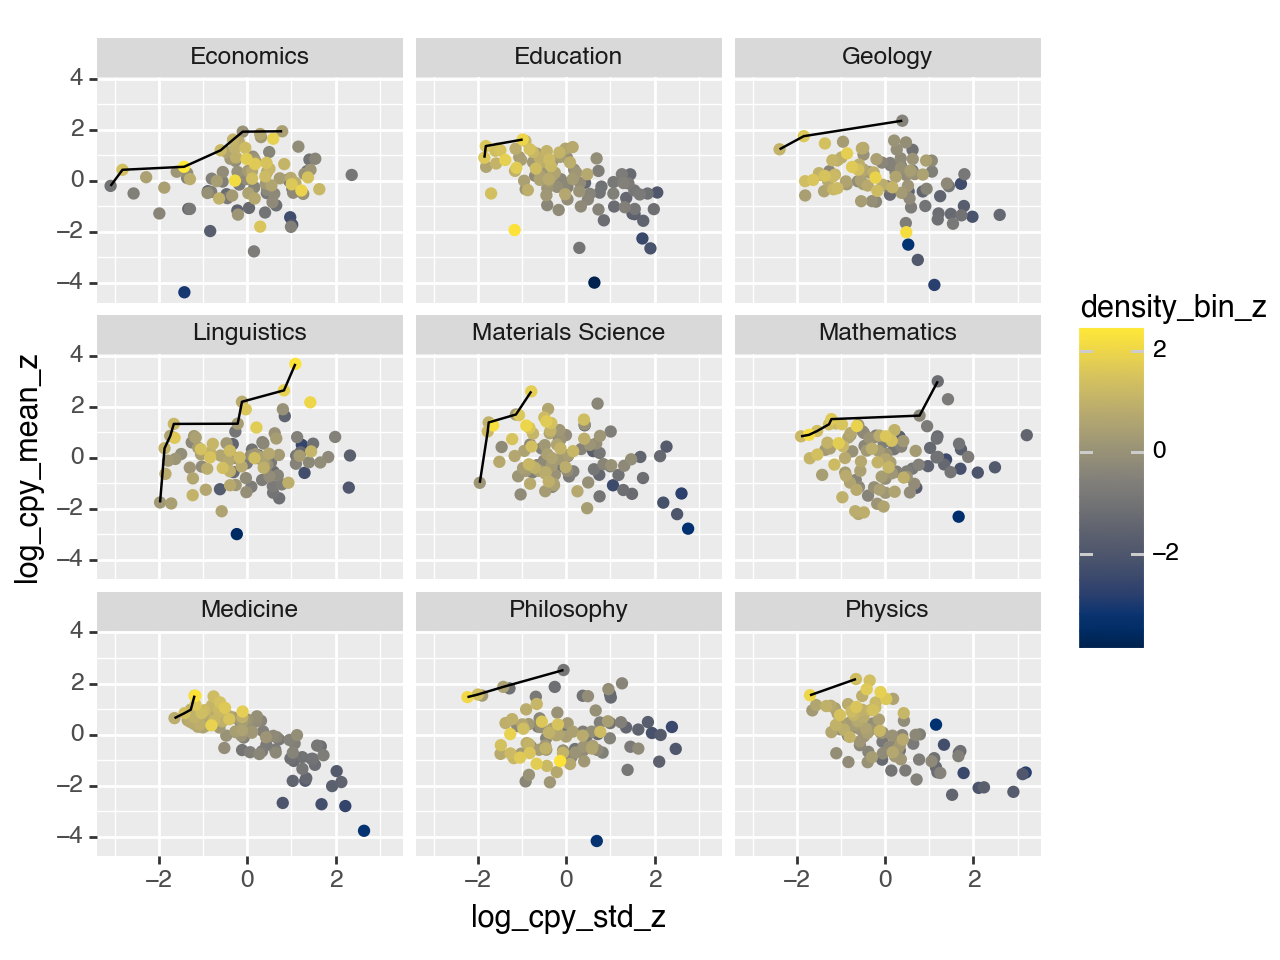

<Figure Size: (640 x 480)>

In [292]:
# df = df_binned_all[df_binned_all["field"] == "Physics"]
df_plot = df_binned_all[df_binned_all["type"] == "observed"]
df_dominant = df_binned_all[df_binned_all["type"] == "dominant"]

(
    pn.ggplot(
        df_plot,
        pn.aes(
            x=risk, # var return
            y=expected_return, # median return
            # color="density_bin_z", # 
        ),
    )
    + pn.geom_point(
        pn.aes(
            color = "density_bin_z",
            # color = "ref_med_z",
            # color = "year_med",
            # color = "optimality",
        )
    )
    + pn.geom_line(
        df_dominant,
        # color = "black",
        # size = 2,
        # alpha = 0.8,
    )
    + pn.facet_wrap("field")
    # + pn.theme_classic()
    + pn.scale_color_continuous("cividis")
)